# Mushroom classification
In this notebook I'll be comparing different ML models and its accuracy in simple image classification task. Dataset consist of 9 different classes of mushrooms.

In [2]:
import plotting
import os
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
from NetUtils import NetUtils
util = NetUtils()
plt.style.use('ggplot')

## Preparing the data

In [3]:
def create_dir(directory):
    if os.path.exists(directory):
        return
    os.mkdir(directory)

def copy_file(src_path, dst_path, file):
    src = os.path.join(src_path, file)
    dst = os.path.join(dst_path, file)
    shutil.copy(src, dst)

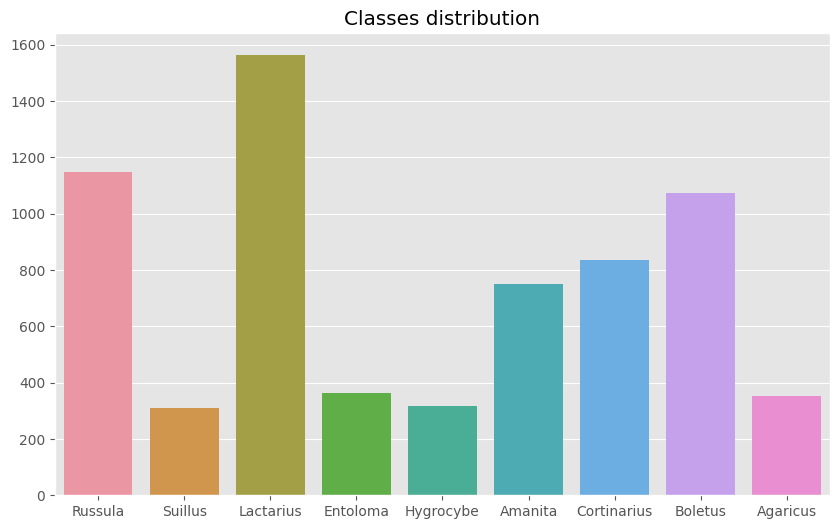

In [4]:
dataset_dir = 'Mushrooms'
classes = os.listdir(dataset_dir)
x = []
y = []
for cl in classes:
    class_length = len(os.listdir(f'{dataset_dir}/{cl}'))
    x.append(cl)
    y.append(class_length)
plt.figure(figsize=(10,6))
sns.barplot(x=x, y=y)
plt.title("Classes distribution")
plt.show()

As we can see we need to deal with imbalanced data here. 
<!-- (Therefore let's use class weighting technique.)-->

In [5]:
base_dir = 'mushrooms'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

create_dir(base_dir)
create_dir(train_dir)
create_dir(val_dir)
create_dir(test_dir)

for parent_dir in [train_dir, test_dir, val_dir]:
    for cl in classes:
        create_dir(f'{parent_dir}/{cl}')

In [6]:
train_percentage = 0.8
val_percentage = 0.1
test_percentage = 0.1
train_samples = 0
val_samples = 0
test_samples = 0

In [7]:
for cl in classes:
    img_directories = os.listdir(f'{dataset_dir}/{cl}')    
    
    class_length = len(img_directories)
    train_length = int(train_percentage * class_length)
    val_length = int(val_percentage * class_length)
    test_length = class_length - train_length - val_length
    
    train_samples += train_length
    val_samples += val_length
    test_samples += test_length
    
    src = f'{dataset_dir}/{cl}'
    dst = f'{train_dir}/{cl}'
    for img in img_directories[:train_length]: # TRAIN
        copy_file(src, dst, img)
    
    dst = f'{val_dir}/{cl}'
    for img in img_directories[train_length : train_length+val_length]: # VALIDATION
        copy_file(src, dst, img)
        
    dst = f'{test_dir}/{cl}'
    for img in img_directories[train_length+val_length:]: # TEST
        copy_file(src, dst, img)

In [8]:
BATCH_SIZE = 32
TRAIN_DATASET_LEN = train_samples
VAL_DATASET_LEN = val_samples
TEST_DATASET_LEN = train_samples
STEPS_PER_EPOCH = TRAIN_DATASET_LEN // BATCH_SIZE
VALIDATION_STEPS = VAL_DATASET_LEN // BATCH_SIZE
EPOCHS = 20
NUM_CLASSES = 9

## Simple CNN model

In [19]:
from SimpleCNN import SimpleCNN
cnn = SimpleCNN(input_shape=(150,150,3), num_classes=NUM_CLASSES)
cnn.create_generators(train_dir, val_dir, test_dir, batch_size=BATCH_SIZE, data_augm=True)
cnn.create_callbacks('cnn.h5')

Found 5367 images belonging to 9 classes.
Found 668 images belonging to 9 classes.
Found 679 images belonging to 9 classes.


In [ ]:
history = cnn.train(steps_per_epoch=STEPS_PER_EPOCH,
                         epochs=EPOCHS,
                         validation_steps=VALIDATION_STEPS)

In [ ]:
print(cnn.clf_report())

## VGG16

In [12]:
from VGG import VGG
vgg = VGG(input_shape=(150,150,3), num_classes=NUM_CLASSES) #,load_weights='vgg16.h5')
vgg.create_generators(train_dir, val_dir, test_dir, batch_size=BATCH_SIZE, data_augm=True)
vgg.create_callbacks('vgg16.h5')

Found 5367 images belonging to 9 classes.
Found 668 images belonging to 9 classes.
Found 679 images belonging to 9 classes.


In [ ]:
history = vgg.train(steps_per_epoch=STEPS_PER_EPOCH,
                   epochs=EPOCHS,
                   validation_steps=VALIDATION_STEPS)

In [ ]:
plotting.loss_plot(history.history)
plotting.acc_plot(history.history)

#### Trying to work with 'extract features' approach

In [9]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten
from keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))

In [ ]:
train_features, train_labels = util.extract_features(conv_base, train_dir, (150,150), TRAIN_DATASET_LEN)
val_features, val_labels = util.extract_features(conv_base, val_dir, (150,150), VAL_DATASET_LEN)
test_features, test_labels = util.extract_features(conv_base, test_dir, (150,150), TEST_DATASET_LEN-1)

In [ ]:
train_features = np.reshape(train_features, (TRAIN_DATASET_LEN, 4*4*512))
val_features = np.reshape(val_features, (VAL_DATASET_LEN, 4*4*512))
test_features = np.reshape(test_features, (TEST_DATASET_LEN-1, 4*4*512))

In [ ]:
dense_clf = Sequential([
    Flatten(),
    Dense(256, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
          bias_regularizer=regularizers.L2(1e-4),
          activity_regularizer=regularizers.L2(1e-5),
          activation='relu'),
    BatchNormalization(),
    #Dense(128, activation='relu'),
    #Dense(128, activation='relu'),
    #Dense(128, activation='relu'),
    #BatchNormalization(),
    #Dropout(0.5),
    Dense(9, activation='softmax')
])
#dense_clf.load_weights('dense_clf_mushrooms.h5')
dense_clf.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])

In [ ]:
history = dense_clf.fit(
    train_features,
    train_labels,
    epochs=20,
    batch_size=BATCH_SIZE,
    validation_data=(val_features, val_labels)
)

In [ ]:
history_dict = history.history
plotting.loss_plot(history_dict)
plotting.acc_plot(history_dict)

## MobileNet

In [ ]:
from MobileNet import MobileNet

mobilenet = MobileNet(input_shape=(224,224,3), num_classes=NUM_CLASSES)
mobilenet.create_generators(train_dir, val_dir, test_dir, batch_size=16)
mobilenet.create_callbacks('mobilenet.h5')

In [ ]:
history = mobilenet.train(steps_per_epoch=STEPS_PER_EPOCH,
               epochs=EPOCHS,
               validation_steps=VALIDATION_STEPS)

#### testing extract features technique

In [ ]:
mobilenet_base = MobileNet(weights='imagenet', include_top=False, input_shape=(150,150,3))

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)
train_features, train_labels = extract_features(mobilenet_base, train_dir, 4697)
val_features, val_labels = extract_features(mobilenet_base, val_dir, 1000)
test_features, test_labels = extract_features(mobilenet_base, test_dir, 1000)

In [ ]:
lambda_coef = 0.001

model = Sequential([
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(lambda_coef)),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(lambda_coef)),
    Dropout(0.5),
    Dense(9, activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_features, 
    train_labels, 
    epochs=30, 
    batch_size=20, 
    validation_data=(val_features, val_labels)
)

In [ ]:
history_dict = history.history
plotting.loss_plot(history_dict, epochs=30)
plotting.acc_plot(history_dict, epochs=30)

## Resnet50

In [ ]:
from ResNet import ResNet
resnet = ResNet(input_shape=(150,150,3), num_classes=NUM_CLASSES)
resnet.create_generators(train_dir, val_dir, test_dir, batch_size=16)
resnet.create_callbacks('resnet.h5')
history = resnet.train(steps_per_epoch=STEPS_PER_EPOCH,
                       epochs=EPOCHS,
                       validation_steps=VALIDATION_STEPS)

## EfficientNetB7

In [ ]:
from EfficientNet import EfficientNet
effnet = EfficientNet(input_shape=(150,150,3), num_classes=9)
effnet.create_generators(train_dir, val_dir, test_dir, batch_size=16)
#effnet.create_callbacks('effnet.h5') # Does not work with callbacks - bug
effnet.summary()

In [ ]:
history = effnet.train(steps_per_epoch=100, epochs=30, validation_steps=16)